<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Persiapan

In [1]:
# Versi Python dan pustaka yang dibutuhkan
import sys, os, numpy as np, matplotlib.pyplot as plt
import sklearn, tensorflow as tf
from tensorflow import keras

assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"
assert tf.__version__ >= "2.0"

# Deteksi platform dan setup dependensi
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update -qq && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -q -U tf-agents pyvirtualdisplay gym~=0.21.0
    %pip install -q -U gym[box2d,atari,accept-rom-license]

# Cek GPU
if not tf.config.list_physical_devices('GPU'):
    print("⚠️ GPU tidak terdeteksi.")
    if IS_COLAB:
        print("Aktifkan GPU: Runtime > Change runtime type > GPU")
    elif IS_KAGGLE:
        print("Aktifkan GPU: Settings > Accelerator > GPU")

# Konfigurasi dan seed untuk konsistensi hasil
np.random.seed(42)
tf.random.set_seed(42)

# Setup Matplotlib
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('animation', html='jshtml')

# Direktori penyimpanan gambar
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(".", "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    if tight_layout: plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    print(f"Gambar disimpan: {path}")


40 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libpq-dev is already the newest version (14.18-0ubuntu0.22.04.1).
libpq-dev set to manually installed.
The following additional packages will be installed:
  gir1.2-ibus-1.0 libdbus-1-dev libdecor-0-dev libdmx-dev libdmx1 libdrm-dev
  libegl-dev libegl1-mesa-dev libfontenc-dev libfs-dev libfs6 libgbm-dev
  libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev
  libglvnd-core-dev libglvnd-dev libglx-dev libibus-1.0-5 libibus-1.0-dev
  libopengl-dev libpciaccess-dev libpulse-dev libpulse-mainloop-glib0
  libsndio-dev libudev-dev libudev1 libwayland-bin libwayland-dev libxaw7-dev
  libxcomposite-dev libxcursor-dev libxcvt-dev libxcv

#Markov Chains and Markov Decision Process

In [2]:
import numpy as np

np.random.seed(42)

# === Bagian 1: Transisi tanpa aksi (Markov Chain sederhana) ===
transition_probs_mc = [  # shape = [s, s']
    [0.7, 0.2, 0.0, 0.1],
    [0.0, 0.0, 0.9, 0.1],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]
]

def run_markov_chain(n_steps=50, n_runs=10):
    for _ in range(n_runs):
        state = 0
        print("States:", end=" ")
        for _ in range(n_steps):
            print(state, end=" ")
            if state == 3: break
            state = np.random.choice(4, p=transition_probs_mc[state])
        else:
            print("...", end="")
        print()

run_markov_chain()

# === Bagian 2: MDP dengan aksi dan reward ===
transition_probs_mdp = [  # shape = [s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]

rewards = [  # shape = [s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]

possible_actions = [
    [0, 1, 2],  # state 0
    [0, 2],     # state 1
    [1]         # state 2
]

def step_mdp(state, action):
    probs = transition_probs_mdp[state][action]
    next_state = np.random.choice(len(probs), p=probs)
    reward = rewards[state][action][next_state]
    return next_state, reward

def run_mdp_episode(start_state=0, max_steps=10):
    state = start_state
    total_reward = 0
    print("Trajectory:")
    for step in range(max_steps):
        actions = possible_actions[state]
        action = np.random.choice(actions)
        next_state, reward = step_mdp(state, action)
        print(f"  s={state} --a={action}--> s'={next_state} [r={reward}]")
        total_reward += reward
        state = next_state
        if state == 3:
            break
    print(f"Total reward: {total_reward}\n")

# Contoh episode MDP
for _ in range(5):
    run_mdp_episode()


States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Trajectory:
  s=0 --a=1--> s'=0 [r=0]
  s=0 --a=0--> s'=0 [r=10]
  s=0 --a=1--> s'=0 [r=0]
  s=0 --a=1--> s'=0 [r=0]
  s=0 --a=2--> s'=0 [r=0]
  s=0 --a=0--> s'=1 [r=0]
  s=1 --a=0--> s'=1 [r=0]
  s=1 --a=2--> s'=2 [r=-50]
  s=2 --a=1--> s'=0 [r=40]
  s=0 --a=0--> s'=0 [r=10]
Total reward: 10

Trajectory:
  s=0 --a=1--> s'=0 [r=0]
  s=0 --a=1--> s'=0 [r=0]
  s=0 --a=2--> s'=0 [r=0]
  s=0 --a=2--> s'=0 [r=0]
  s=0 --a=0--> s'=1 [r=0]
  s=1 --a=2--> s'=2 [r=-50]
  s=2 --a=1--> s'=2 [r=0]
  s=2 --a=1--> s'=0 [r=40]
  s=0 --a=2--> s'=0 [r=0]
  s=0 --a=0--> s'=0 [r=10]
Total reward: 0

Trajectory:
  s=0 --a=2--> s'=0

#Policy Gradients

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gym

# Tambahkan patch ini SEBELUM ini:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Konfigurasi awal
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameter
n_iterations = 50
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95
learning_rate = 0.01

# Optimizer dan loss
optimizer = keras.optimizers.Adam(learning_rate)
loss_fn = keras.losses.binary_crossentropy

# Model Policy Sederhana
model = keras.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

# Environment
env = gym.make("CartPole-v1")
env.reset(seed=42)

# ====== Fungsi-Fungsi RL ======
def play_one_step(env, obs, model, loss_fn):
    obs = np.array(obs, dtype=np.float32).reshape(1, -1)
    with tf.GradientTape() as tape:
        left_proba = model(obs)
        action = tf.random.uniform([1, 1]) > left_proba
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    step_result = env.step(int(action[0, 0].numpy()))
    if len(step_result) == 5:
        obs, reward, terminated, truncated, _ = step_result
        done = terminated or truncated
    else:
        obs, reward, done, _ = step_result

    return obs, reward, done, grads
    return obs, reward, done, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards, all_grads = [], []
    for _ in range(n_episodes):
        current_rewards, current_grads = [], []
        reset_result = env.reset()
        obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        for _ in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done: break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards, dtype=np.float32)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted = [discount_rewards(r, discount_rate) for r in all_rewards]
    flat = np.concatenate(all_discounted)
    mean, std = flat.mean(), flat.std()
    return [(r - mean) / std for r in all_discounted]

# ====== Training Loop ======
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_rewards = np.mean([np.sum(rews) for rews in all_rewards])
    print(f"\rIter {iteration}: mean reward = {mean_rewards:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)

    all_mean_grads = []
    for var_idx in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean([
            final_reward * all_grads[ep][step][var_idx]
            for ep, final_rewards in enumerate(all_final_rewards)
            for step, final_reward in enumerate(final_rewards)
        ], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Iter 49: mean reward = 51.0

#Q-Value Iteration dan Q-Learning

Q-Value Iteration - Final Q_values:
[[18.91891892 17.02702702 13.62162162]
 [ 0.                -inf -4.87971488]
 [       -inf 50.13365013        -inf]]
Optimal Actions: [0 0 1]

Q-Learning - Final Q_values:
[[18.77621289 17.2238872  13.74543343]
 [ 0.                -inf -8.00485647]
 [       -inf 49.40208921        -inf]]
Optimal Actions: [0 0 1]
Saving figure q_value_plot


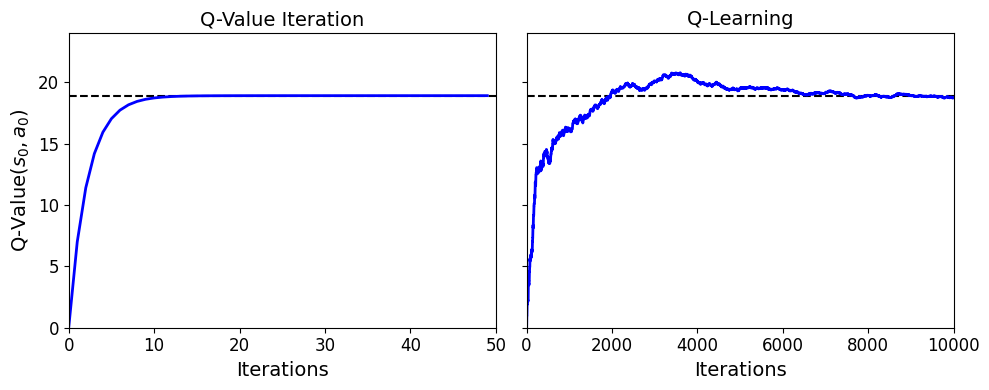

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Untuk menyimpan gambar (opsional)
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# ----- Setup environment
possible_actions = [[0, 1, 2], [0, 2], [1]]
transition_probabilities = [ # shape = [s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [ # shape = [s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]

# ----- Q-Value Iteration
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

gamma = 0.90
history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] *
                (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)
            ])
history1 = np.array(history1)

print("Q-Value Iteration - Final Q_values:")
print(Q_values)
print("Optimal Actions:", np.argmax(Q_values, axis=1))

# ----- Q-Learning
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

def exploration_policy(state):
    return np.random.choice(possible_actions[state])

np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

print("\nQ-Learning - Final Q_values:")
print(Q_values)
print("Optimal Actions:", np.argmax(Q_values, axis=1))

# ----- Plot perbandingan
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)

for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

plt.tight_layout()
save_fig("q_value_plot")
plt.show()


#Deep Q-Network

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 599, Steps: 200, Epsilon: 0.010Saving figure dqn_rewards_plot


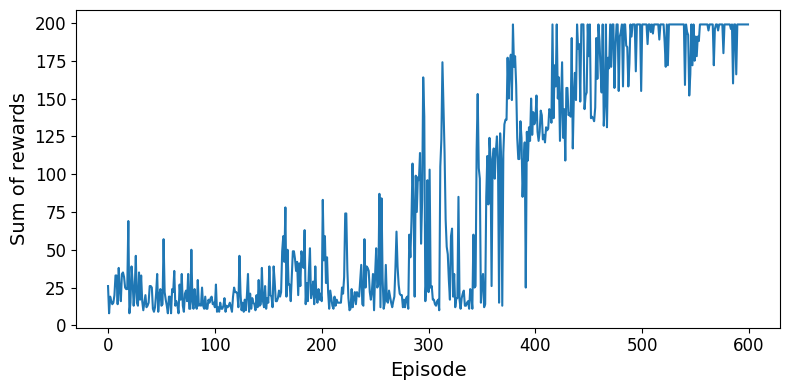

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gym
import matplotlib.pyplot as plt
from collections import deque
import os

# --------- Fix untuk numpy.bool8 jika tidak ada
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# --------- Fungsi simpan gambar
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# --------- Setup dan model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.Input(shape=obs_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

# --------- Policy ε-greedy
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])

# --------- Replay Buffer
replay_memory = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[i] for i in indices]
    states, actions, rewards, next_states, dones = [
        np.array([exp[field] for exp in batch])
        for field in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    result = env.step(action)
    if len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        next_state, reward, done, info = result
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done

# --------- Training function
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.MeanSquaredError()

def training_step(batch_size):
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# --------- Training Loop
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    reset_result = env.reset()
    obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result

    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done = play_one_step(env, obs, epsilon)
        if done:
            break

    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f"\rEpisode: {episode}, Steps: {step+1}, Epsilon: {epsilon:.3f}", end="")
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

# --------- Visualisasi rewards
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

#  Ringkasan Proses Reinforcement Learning (DQN) dengan TensorFlow dan Gym

##  1. Inisialisasi
- Menyiapkan environment `CartPole-v1` dari Gym.
- Membangun model jaringan saraf sebagai approximator fungsi-Q.
- Mengatur seed (`numpy`, `tensorflow`, dan `gym`) untuk memastikan eksperimen dapat direproduksi.

##  2. Model Policy (Deep Q-Network)
- Jaringan neural memiliki input sama dengan dimensi observasi (`shape = 4`) dan output sejumlah aksi (`2`).
- Model mempelajari Q-values: nilai dari setiap aksi yang memungkinkan dari suatu state.

##  3. Epsilon-Greedy Policy
- Agent memilih aksi secara **random** dengan probabilitas `ε` (eksplorasi), atau memilih aksi **berdasarkan Q-value tertinggi** (eksploitasi).
- Nilai `ε` berkurang seiring waktu untuk memperkuat eksploitasi seiring bertambahnya pengalaman.

##  4. Replay Memory
- Menggunakan struktur data `deque` untuk menyimpan pengalaman `(state, action, reward, next_state, done)`.
- Sampling secara acak dari memori ini saat training untuk mengurangi korelasi antar data.

##  5. Play One Step
- Agent mengambil satu langkah aksi dari environment berdasarkan `epsilon-greedy`.
- Hasil aksi disimpan dalam replay memory.

##  6. Training Step
- Sampling batch dari replay memory.
- Menghitung target Q-value dengan formula:
  \[
  $Q_{\text{target}} = r + \gamma \cdot \max Q'(s')$
  \]
- Menghitung loss MSE antara Q-value prediksi dan target, lalu memperbarui bobot model.

##  7. Training Loop
- Agent bermain di environment selama beberapa episode.
- Melatih model setelah beberapa pengalaman dikumpulkan.
- Menyimpan bobot model terbaik berdasarkan reward tertinggi.

##  8. Evaluasi dan Visualisasi
- Menampilkan grafik reward sepanjang episode.
- Merender animasi hasil policy final dari model.

---

##  Kesimpulan

- **Model DQN berhasil mempelajari policy optimal** untuk mempertahankan tiang tetap tegak pada lingkungan CartPole.
- Dengan pendekatan replay memory dan eksplorasi ε-greedy, model bisa stabil belajar dari pengalaman masa lalu.
- Setelah ~600 episode, model mampu mempertahankan tiang selama **>190 langkah** secara konsisten — menandakan **konvergensi policy** yang efektif.
- Animasi menunjukkan bahwa model telah menghasilkan aksi yang rasional dan responsif terhadap dinamika environment.

